# Classifying Planets

## Introduction

In this classification problem, we embark on a journey where we are presented with a synthetic dataset of planets and moons of our solar system. Our mission is clear: **classify from an image the planet or moon**.

In [1]:
import os
import random
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf

2023-06-21 11:35:33.353940: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set the random seed for reproducibility
seed = 77

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.random.set_seed(seed)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

## Load the data

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "data/raw",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128)
)

Found 1605 files belonging to 11 classes.


## Exploring the data

In [4]:
print('Data shape:', dataset.element_spec[0].shape)
print('Data type:', dataset.element_spec[0].dtype)
print('Label shape:', dataset.element_spec[1].shape)
print('Label type:', dataset.element_spec[1].dtype)

labels = dataset.class_names

# Print the labels
print("Labels:")
for i, label in enumerate(labels):
    print(f"{i:4}: {label}")


Data shape: (None, 128, 128, 3)
Data type: <dtype: 'float32'>
Label shape: (None,)
Label type: <dtype: 'int32'>
Labels:
   0: Earth
   1: Jupiter
   2: MakeMake
   3: Mars
   4: Mercury
   5: Moon
   6: Neptune
   7: Pluto
   8: Saturn
   9: Uranus
  10: Venus


2023-06-21 11:35:36.139106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1605]
	 [[{{node Placeholder/_4}}]]
2023-06-21 11:35:36.139785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1605]
	 [[{{node Placeholder/_4}}]]


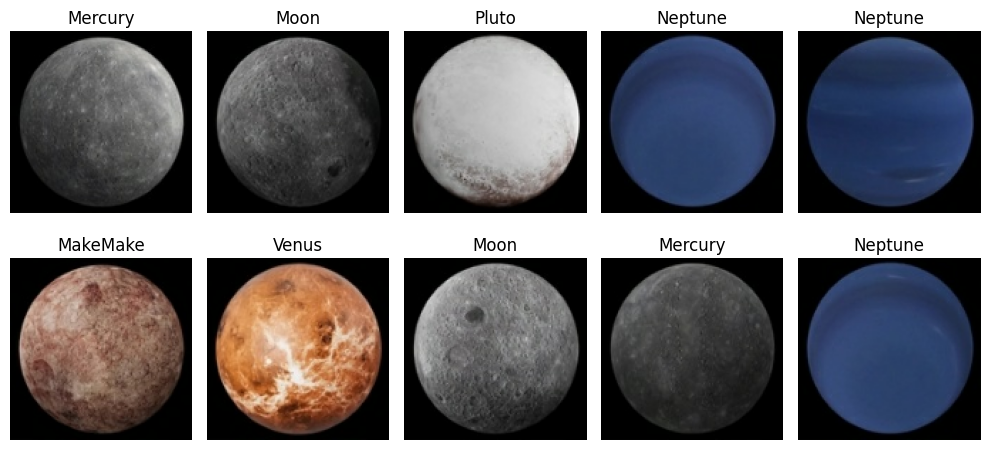

In [5]:
# Plot 10 sample images
plt.figure(figsize=(10, 5), tight_layout=True)
for images, label_idxs in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[label_idxs[i].numpy()])
        plt.axis("off")

## Preparing the data

The following steps are performed to prepare the data:

- Shuffling the data
- Splitting the data into training and validation sets

In [6]:
ds_train, ds_test = tf.keras.utils.image_dataset_from_directory(
    "data/raw",
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    batch_size=32,
    image_size=(32, 32),
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="both",
)

Found 1605 files belonging to 11 classes.
Using 1284 files for training.
Using 321 files for validation.


2023-06-21 11:35:38.249944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1284]
	 [[{{node Placeholder/_4}}]]
2023-06-21 11:35:38.250788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1284]
	 [[{{node Placeholder/_4}}]]


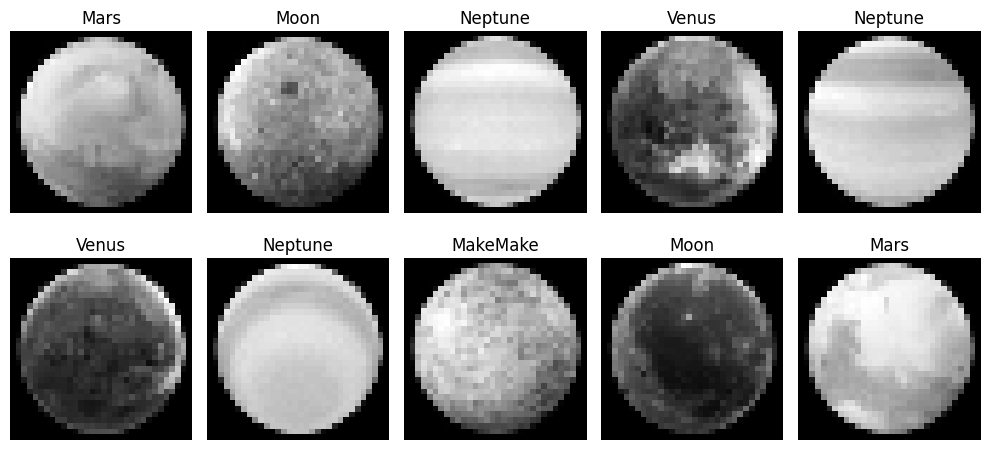

In [7]:
# Plot 10 sample images
plt.figure(figsize=(10, 5), tight_layout=True)
for images, label_idxs in ds_train.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
        plt.title(labels[label_idxs[i].numpy()])
        plt.axis("off")

## Training the model

In [8]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(
            32, (3, 3), activation="relu", input_shape=(32, 32, 1)
        ),
        tf.keras.layers.MaxPooling2D((3, 3)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(11),
    ]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense (Dense)               (None, 64)                204864    
                                                                 
 dense_1 (Dense)             (None, 11)                715       
                                                                 
Total params: 205,899
Trainable params: 205,899
Non-trainable params: 0
__________________________________________________

In [9]:
model.fit(
    ds_train,
    epochs=5,
    validation_data=ds_test,
)

Epoch 1/5


2023-06-21 11:35:39.780399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1284]
	 [[{{node Placeholder/_4}}]]
2023-06-21 11:35:39.781262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1284]
	 [[{{node Placeholder/_0}}]]


40/41 [============================>.] - ETA: 0s - loss: 9.8917 - sparse_categorical_accuracy: 0.1883 

2023-06-21 11:35:41.888791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [321]
	 [[{{node Placeholder/_4}}]]
2023-06-21 11:35:41.889156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [321]
	 [[{{node Placeholder/_4}}]]


41/41 [==============================] - 2s 26ms/step - loss: 9.8702 - sparse_categorical_accuracy: 0.1893 - val_loss: 3.5863 - val_sparse_categorical_accuracy: 0.3769
Epoch 2/5
41/41 [==============================] - 1s 24ms/step - loss: 3.0988 - sparse_categorical_accuracy: 0.4322 - val_loss: 2.5116 - val_sparse_categorical_accuracy: 0.5078
Epoch 3/5
41/41 [==============================] - 1s 22ms/step - loss: 2.0110 - sparse_categorical_accuracy: 0.5623 - val_loss: 1.3047 - val_sparse_categorical_accuracy: 0.6262
Epoch 4/5
41/41 [==============================] - 1s 23ms/step - loss: 1.4358 - sparse_categorical_accuracy: 0.6386 - val_loss: 1.0890 - val_sparse_categorical_accuracy: 0.6511
Epoch 5/5
41/41 [==============================] - 1s 22ms/step - loss: 1.1381 - sparse_categorical_accuracy: 0.6791 - val_loss: 1.1370 - val_sparse_categorical_accuracy: 0.6885


## Model Evaluation

Evaluate the model on the validation set.

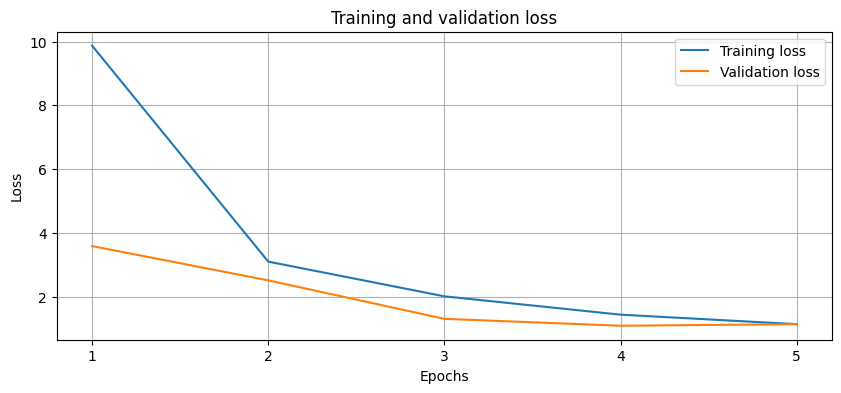

In [10]:
# Plot the training and validation loss
history = model.history.history
epochs = range(1, len(history["loss"]) + 1)

plt.figure(figsize=(10, 4))
plt.plot(epochs, history["loss"], label="Training loss")
plt.plot(epochs, history["val_loss"], label="Validation loss")
plt.xticks(epochs)
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Print validation metrics
val_loss, val_acc = model.evaluate(ds_test)
print(f"Validation loss: {val_loss:.2f}")
print(f"Validation accuracy: {val_acc * 100:.2f}%")

11/11 [==============================] - 0s 11ms/step - loss: 1.1370 - sparse_categorical_accuracy: 0.6885
Validation loss: 1.14
Validation accuracy: 68.85%


2023-06-21 11:35:46.492727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [321]
	 [[{{node Placeholder/_4}}]]
2023-06-21 11:35:46.493162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [321]
	 [[{{node Placeholder/_4}}]]
2023-06-21 11:35:46.569279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [32,32,32

1/1 [==============================] - 0s 132ms/step


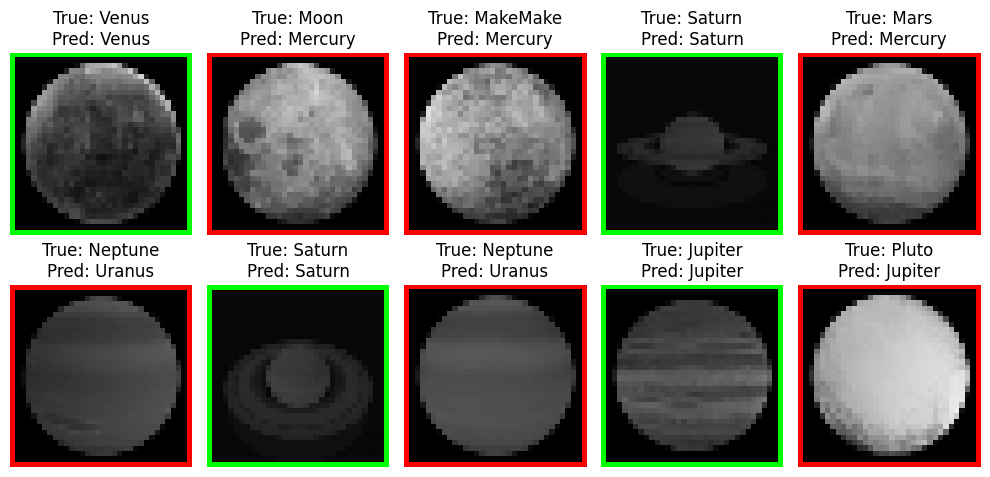

In [12]:
# Take 10 random images from the test set and show the model's predictions
plt.figure(figsize=(10, 5), tight_layout=True)
for images, label_idxs in ds_test.take(1):
    preds = model.predict(images)
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        img = images[i].numpy().astype("uint8")
        # Convert image to rgb if grayscale
        if img.shape[-1] == 1:
            img = np.squeeze(img, axis=-1)
            img = np.stack((img,) * 3, axis=-1)
        true_label = labels[label_idxs[i].numpy()]
        pred_label = labels[np.argmax(preds[i])]
        # Add red border if the prediction is wrong else add green border
        img = np.pad(img, pad_width=((1, 1), (1, 1), (0, 0)))
        if true_label != pred_label:
            img[0,:,0] = 255  # Top border
            img[-1,:,0] = 255  # Bottom border
            img[:,0,0] = 255  # Left border
            img[:,-1,0] = 255  # Right border
        else:
            img[0,:,1] = 255
            img[-1,:,1] = 255
            img[:,0,1] = 255
            img[:,-1,1] = 255

        plt.imshow(img)
        plt.title(
            f"True: {true_label}\n"
            f"Pred: {pred_label}"
        )
        plt.axis("off")
plt.show()

11/11 [==============================] - 0s 6ms/step


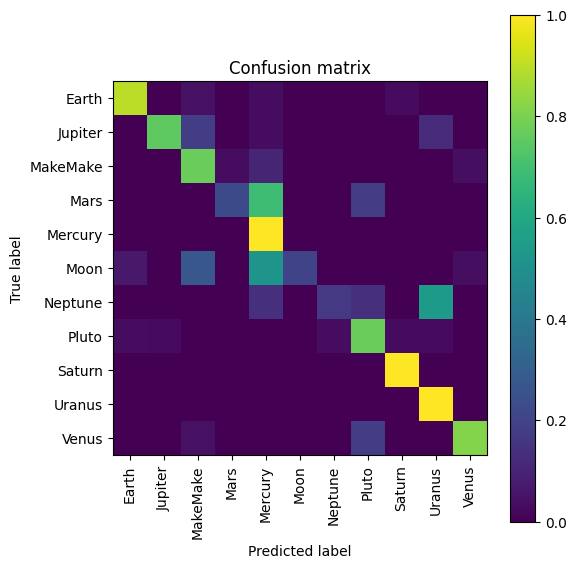

In [13]:
# Show confusion matrix of confidence per class for the test set
plt.figure(figsize=(6, 6), tight_layout=True)
preds = model.predict(ds_test)

conf_matrix = tf.math.confusion_matrix(
    labels=tf.concat([y for _, y in ds_test], axis=0),
    predictions=tf.argmax(preds, axis=1),
    num_classes=len(labels),
)

conf_matrix = conf_matrix / tf.reduce_sum(conf_matrix, axis=1)
plt.imshow(conf_matrix)
plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.show()

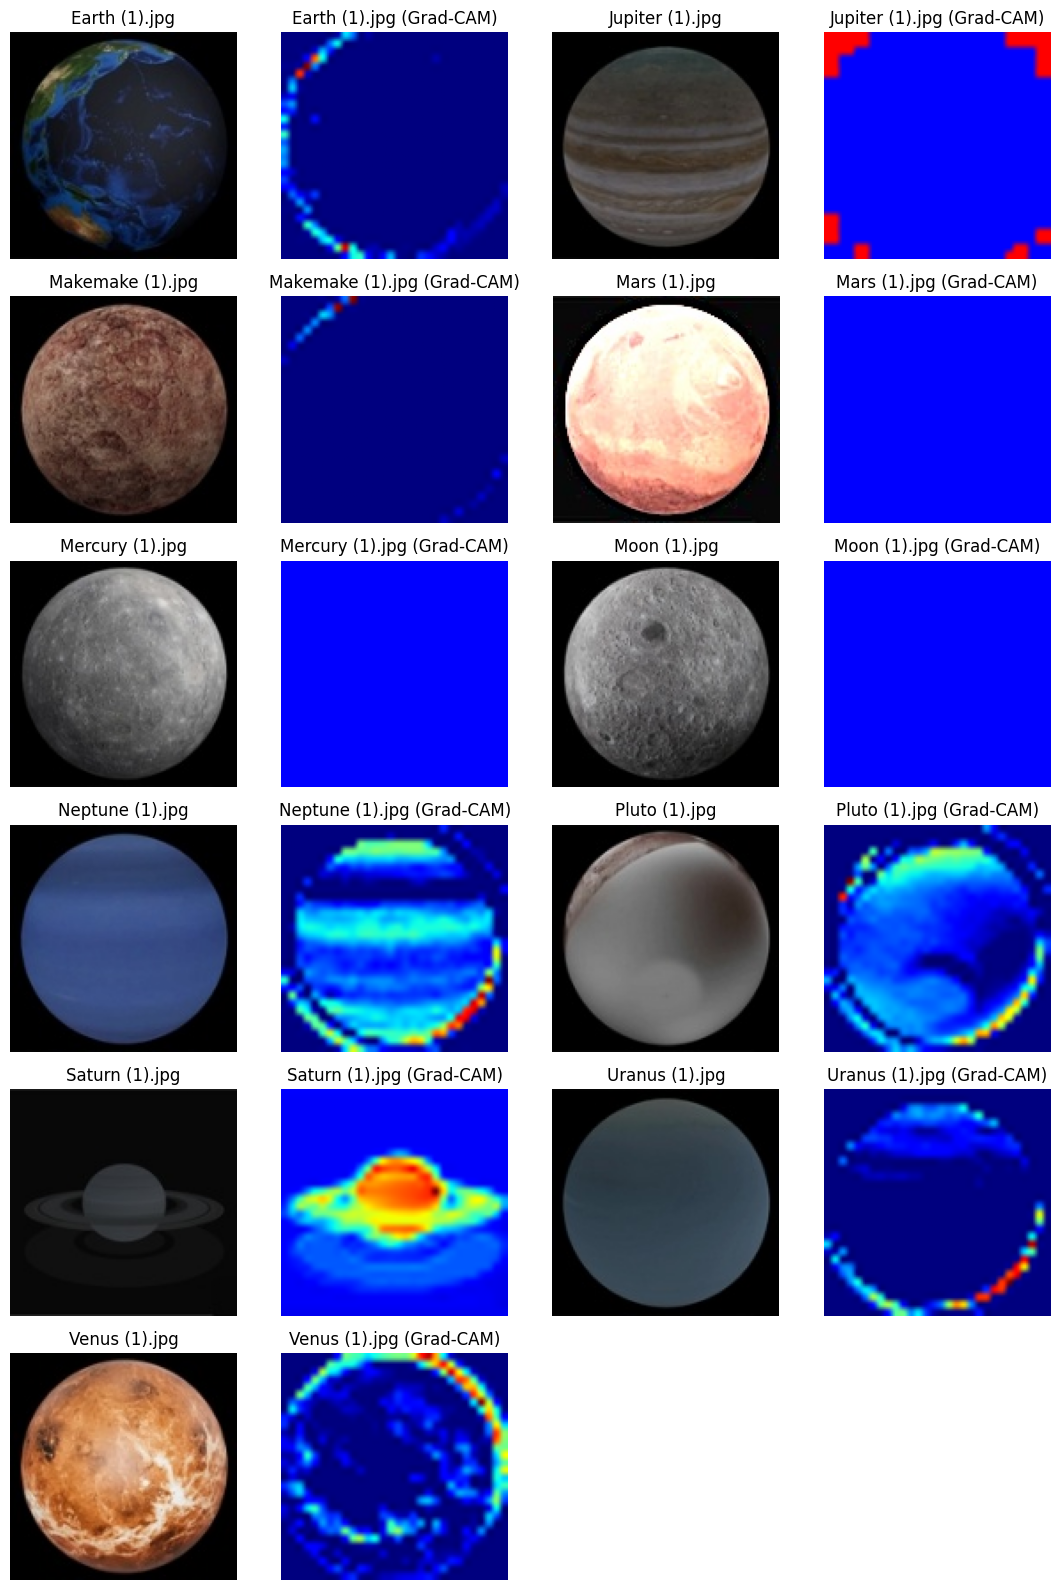

In [14]:
# Explain the model's predictions using Grad-CAM
def make_gradcam_heatmap(img, grad_model):
    # We add a dimension to transform our array into a "batch"
    # of size (1, 32, 32, 1)
    img = np.expand_dims(img, axis=0)

    # Resize and convert the image
    input_w = grad_model.input_shape[1]
    input_h = grad_model.input_shape[2]
    img = tf.image.resize(img, (input_w, input_h))
    grayscale = grad_model.input_shape[3] == 1
    if grayscale:
        img = tf.image.rgb_to_grayscale(img)

    # We compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# We create a model that maps the input image to the activations
# of the last conv layer as well as the output predictions
last_conv_layer = list(filter(lambda x: "conv" in x.name, model.layers))[-1]
grad_model = tf.keras.models.Model(
    model.inputs, [last_conv_layer.output, model.output]
)

data_path = Path("data/raw")
classes = sorted(filter(lambda p: p.is_dir(), data_path.glob("*")))

plt.figure(figsize=(11, 16), tight_layout=True)
for i, class_path in enumerate(classes):
    img_path = list(sorted(class_path.glob("*")))[0]
    img_fn = img_path.name
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    heatmap = make_gradcam_heatmap(img, grad_model)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    plt.subplot(6, 4, i * 2 + 1)
    plt.imshow(img / 255)
    plt.axis("off")
    plt.title(img_fn)

    plt.subplot(6, 4, i * 2 + 2)
    plt.imshow(jet_heatmap / 255)
    plt.axis("off")
    plt.title(img_fn + " (Grad-CAM)")

plt.show()